<a href="https://colab.research.google.com/github/Varsha-Garikapati/demo-repo/blob/main/Detecting_COVID_19_with_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<strong>
    <h1 align='center'>Detecting COVID-19 with Chest X Ray using PyTorch</h1>
</strong>

---



<p align='center'>
  <a href="#">
    <img src='https://github.com/mohd-faizy/DataScience-Projects/blob/main/Projects_png/09_proj.png?raw=true' alt="covid.png">
  </a>
</p>

__Image classification__ of __Chest X Rays__ in one of __three__ classes:
- __Normal__
- __Viral Pneumonia__
- __COVID-19__

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

## __Task-1__ Downloding the Dataset from Kaggle

In [3]:
# gpu
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
# Create api key -> account ->Create New Token
# .json file is genrated

!pip install -q kaggle
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"varru12","key":"7cc4464191ed7813d172aa22c5d33315"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [6]:
!ls

'kaggle (3).json'   sample_data


In [7]:
! unzip -uq '/content/covid19-radiography-database.zip' -d '/content/COVID-19_Radiography_Database'

unzip:  cannot find or open /content/covid19-radiography-database.zip, /content/covid19-radiography-database.zip.zip or /content/covid19-radiography-database.zip.ZIP.


In [8]:
ls

'kaggle (3).json'   sample_data/


In [9]:
!ls /content/COVID-19_Radiography_Database


ls: cannot access '/content/COVID-19_Radiography_Database': No such file or directory


In [36]:
!ls /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset


 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


## __Task - 2__ Importing Libraries

In [8]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.8.0+cu126


## __Task - 3__ Preparing Training and Test Sets

In [127]:
import os, shutil, random

# ✅ Correct paths
root_dir = '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset'
class_names = ['Normal', 'Viral Pneumonia', 'COVID']  # add 'Lung_Opacity' if needed

# ✅ Create test directories
test_dir = os.path.join(root_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
for c in class_names:
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

# ✅ Randomly move 20% of images to test set
for c in class_names:
    class_path = os.path.join(root_dir, c, 'images')  # << FIXED HERE
    if not os.path.exists(class_path):
        print(f"⚠️ Skipping {c} — no 'images' folder found")
        continue

    images = [x for x in os.listdir(class_path) if x.lower().endswith('png')]
    random.shuffle(images)

    test_size = int(0.2 * len(images))
    test_images = images[:test_size]

    for img in test_images:
        src_path = os.path.join(class_path, img)
        dst_path = os.path.join(test_dir, c, img)
        shutil.move(src_path, dst_path)

print("✅ Train-test split completed successfully!")


✅ Train-test split completed successfully!


In [128]:
!ls /content/COVID-19_Radiography_Database


COVID-19_Radiography_Dataset


## __Task - 4__ Creating Custom Dataset

In [129]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        self.image_dirs = image_dirs
        self.transform = transform
        self.classes = list(image_dirs.keys())
        self.images = {cls: self.get_images(cls) for cls in self.classes}
        self.class_names = list(self.image_dirs.keys())

    def get_images(self, class_name):
        images_path = self.image_dirs[class_name]  # ✅ corrected path logic
        images = [x for x in os.listdir(images_path) if x.lower().endswith(('png', 'jpg', 'jpeg'))]
        print(f'Found {len(images)} {class_name} examples')
        return images

    def __len__(self):
        return sum(len(self.images[cls]) for cls in self.classes)

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)


In [130]:
!ls /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		      test
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


## __Task - 5__ Image Transformations

In [131]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [132]:
!ls /content


 COVID-19_Radiography_Database	   'kaggle (1).json'   kaggle.json
 covid19-radiography-database.zip  'kaggle (3).json'   sample_data


In [133]:
!ls /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset


 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		      test
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


In [134]:
!find /content -type d -iname "*radiography*"


/content/COVID-19_Radiography_Database
/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset


In [135]:
train_dirs = {
    'normal': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/Normal/images',
    'viral': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'covid': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/COVID/images'
}

test_dirs = {
    'normal': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/Normal',
    'viral': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/Viral Pneumonia',
    'covid': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/COVID'
}


In [136]:
for cls in test_dirs.keys():
    path = test_dirs[cls]
    print(cls, len(os.listdir(path)), "files in", path)


normal 3668 files in /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/Normal
viral 484 files in /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/Viral Pneumonia
covid 723 files in /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/COVID


In [137]:
!ls /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/Normal | head


images
masks


## __Task - 6__ Prepare DataLoader

In [138]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)
print(len(train_dataset))

Found 6524 normal examples
Found 861 viral examples
Found 2893 covid examples
10278


In [139]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 3668 normal examples
Found 484 viral examples
Found 723 covid examples


In [140]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 1713
Number of test batches 813


## __Task - 7__ Data Visualization

In [141]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

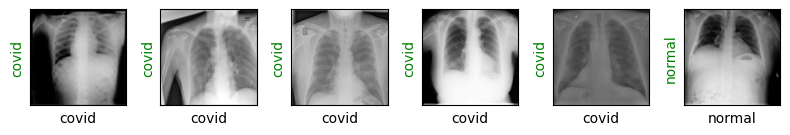

In [142]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

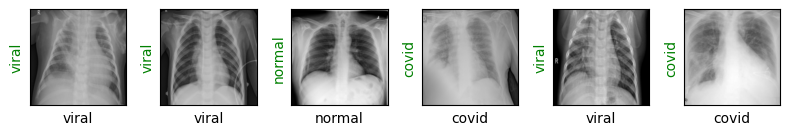

In [143]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## __Task - 8__ Creating the Model

In [144]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [145]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [146]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

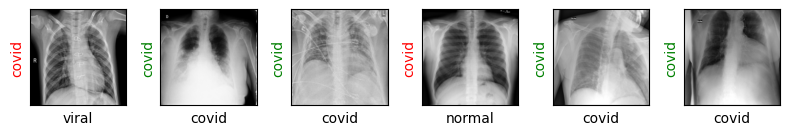

In [147]:
show_preds()

## __Task - 9__ Training the Model

In [148]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.3465, Accuracy: 0.3331


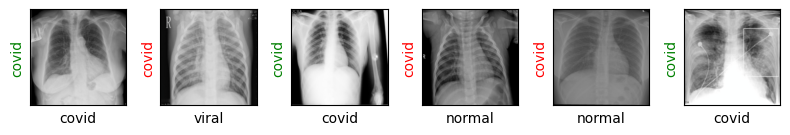

Evaluating at step 20
Validation Loss: 0.8051, Accuracy: 0.7301


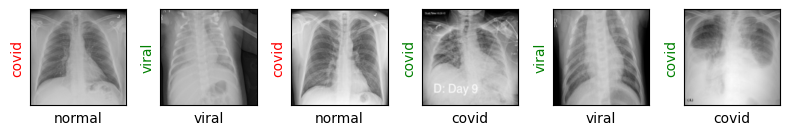

Evaluating at step 40
Validation Loss: 0.5826, Accuracy: 0.8066


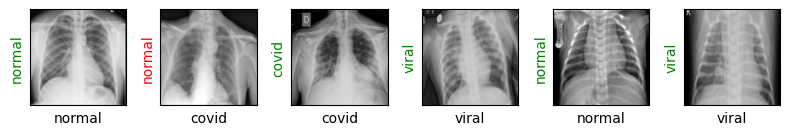

Evaluating at step 60
Validation Loss: 0.3797, Accuracy: 0.8613


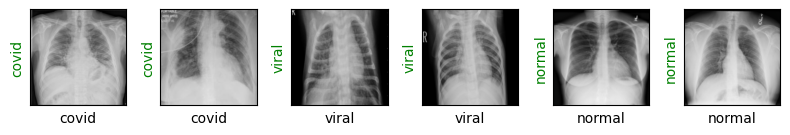

Evaluating at step 80
Validation Loss: 0.3145, Accuracy: 0.8837


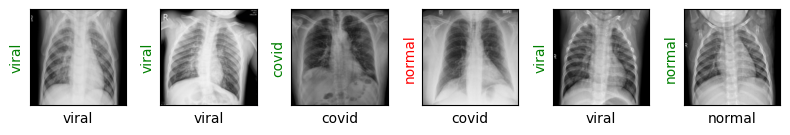

Evaluating at step 100
Validation Loss: 0.2767, Accuracy: 0.8958


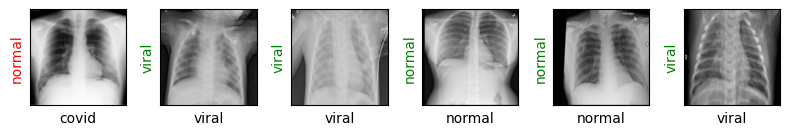

Evaluating at step 120
Validation Loss: 0.2465, Accuracy: 0.9083


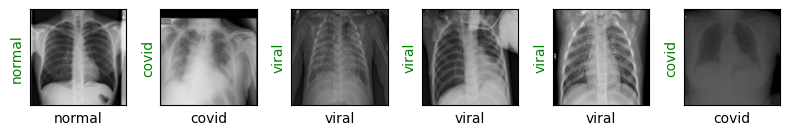

Evaluating at step 140
Validation Loss: 0.2593, Accuracy: 0.8913


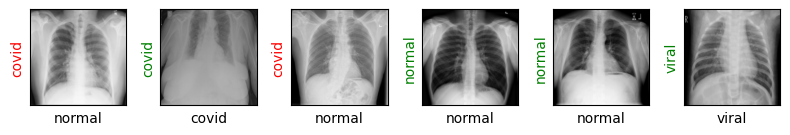

Evaluating at step 160
Validation Loss: 0.2294, Accuracy: 0.9182


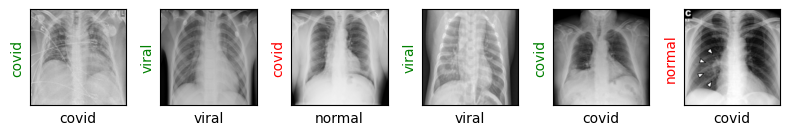

Evaluating at step 180
Validation Loss: 0.2094, Accuracy: 0.9296


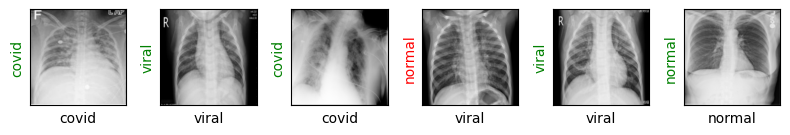

Evaluating at step 200
Validation Loss: 0.1905, Accuracy: 0.9307


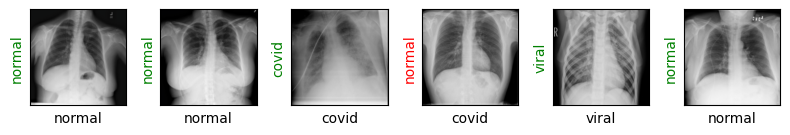

Evaluating at step 220
Validation Loss: 0.1996, Accuracy: 0.9335


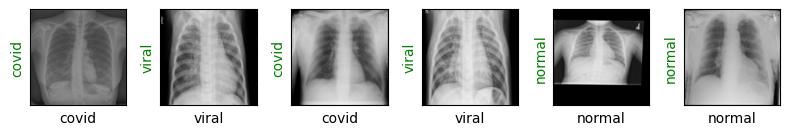

Evaluating at step 240
Validation Loss: 0.2058, Accuracy: 0.9280


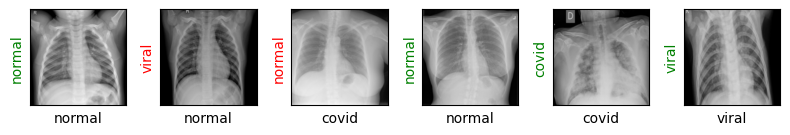

Evaluating at step 260
Validation Loss: 0.2155, Accuracy: 0.9036


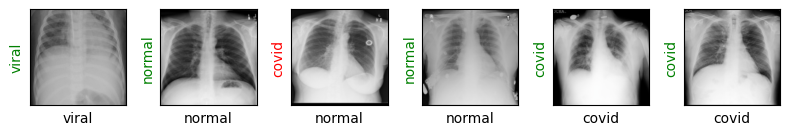

Evaluating at step 280
Validation Loss: 0.1548, Accuracy: 0.9508


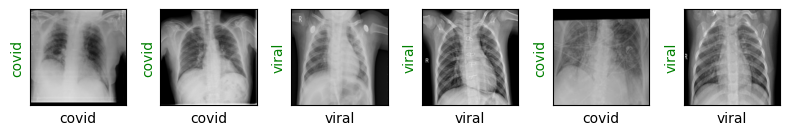

Performance condition satisfied, stopping..
CPU times: user 1h 2min 34s, sys: 47.1 s, total: 1h 3min 21s
Wall time: 1h 3min 41s


In [149]:
%%time

train(epochs=1)

## __Task - 10__ Show the Predictions

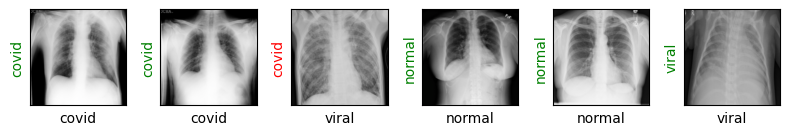

In [150]:
show_preds()

## __Task - 11__ *Saving* the Model

In [151]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

## __Task -12__ Inference on a Single Image

In [2]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

NameError: name 'torchvision' is not defined

In [165]:
import os

test_dir = '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test'
print(os.listdir(test_dir))


['COVID-19', 'COVID', 'Viral Pneumonia', 'Normal']


In [1]:
image_path = '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/Viral Pneumonia/Viral Pneumonia-992.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

NameError: name 'predict_image_class' is not defined